In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R

In [218]:
def load_data(file_path):
    df = pd.read_csv(file_path)

    timestamps = np.array(df.iloc[:, 0].values)
    accel_data = df.iloc[:, 1:4].values * 9.81 # convert to m/s^2
    gyro_data = df.iloc[:, 5:].values

    return timestamps, accel_data, gyro_data


def load_all_data(folder_path):
    timestamps_list, accel_list, gyro_list = [], [], []
    prev_timestamp = 0

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith(".csv"):
                file_path = os.path.join(subfolder_path, file_name)
                timestamps, accel_data, gyro_data = load_data(file_path)
                timestamps += np.int64(prev_timestamp)
                prev_timestamp = timestamps[-1]
                timestamps_list.append(timestamps)
                accel_list.append(accel_data)
                gyro_list.append(gyro_data)

    # Merge all extracted data
    timestamps = np.concatenate(timestamps_list)
    accel_data = np.vstack(accel_list)
    gyro_data = np.vstack(gyro_list)

    invalid_indices = np.where(np.isnan(timestamps)) or np.where(
        np.isnan(accel_data)) or np.where(np.isnan(gyro_data))
    timestamps = np.delete(timestamps, invalid_indices)
    accel_data = np.delete(accel_data, invalid_indices, axis=0)
    gyro_data = np.delete(gyro_data, invalid_indices, axis=0)

    return timestamps, accel_data, gyro_data

In [259]:
def remove_outliers_iqr(data, threshold=1.5):
    """Removes outliers using the IQR method."""
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    mask = (data >= lower_bound) & (data <= upper_bound)
    return data[np.all(mask, axis=1)]

def detect_static_intervals(accel_data, window_size=50, threshold_factor=5):
    """ Detects static intervals using variance-based thresholding. """
    variances = np.array([np.var(accel_data[i:i + window_size], axis=0)
                         for i in range(len(accel_data) - window_size)])
    threshold = np.mean(variances) * threshold_factor  # Adaptive threshold

    static_intervals = np.where(
        np.linalg.norm(variances, axis=1) < threshold)[0]
    return static_intervals

timestamps, accel_data, gyro_data = load_all_data('./data')
static_indices = detect_static_intervals(remove_outliers_iqr(accel_data))
static_timestamps = timestamps[static_indices]
static_accel_data = accel_data[static_indices]
static_gyro_data = gyro_data[static_indices]

print(f"Detected {len(static_indices)} static intervals")

Detected 15820 static intervals


[ 4.58357455  5.68499972 -6.44842592]
Mean Calibrated Acceleration Magnitude: 9.7422 m/s²


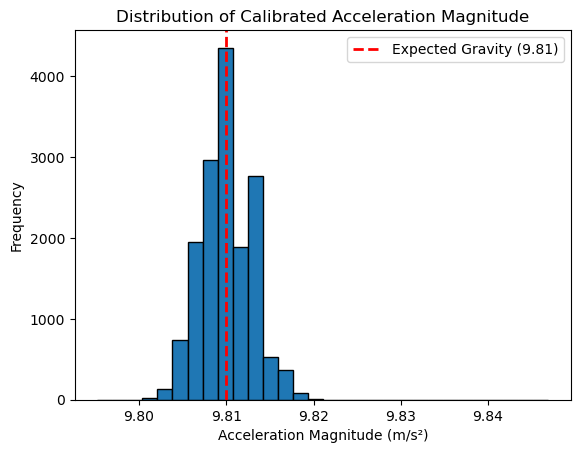

In [263]:
def accel_calibration(params, static_accel_data, return_corrected=False):
    """ Calibration function for accelerometer. """
    scale_factors = np.diag(params[:3])
    biases = params[3:6]
    misalignment = np.array([[1, params[6], params[7]],
                             [params[8], 1, params[9]],
                             [params[10], params[11], 1]])

    corrected = ((static_accel_data - biases) @ scale_factors) @ misalignment.T

    if return_corrected:
        return corrected
    return np.linalg.norm(corrected, axis=1) - 9.81


def apply_accel_calibration(static_accel_data):
    # Less aggressive initial misalignment
    initial_guess = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

    # Perform optimization with bounds
    result = least_squares(accel_calibration, initial_guess, args=(
        static_accel_data,), method='lm')
    accel_corrected = accel_calibration(
        result.x, static_accel_data, return_corrected=True)
    return accel_corrected


def test_accel_calibration(static_accel_data):
    accel_corrected = apply_accel_calibration(static_accel_data)
    mean_accel = accel_corrected.mean(axis=0)
    print(mean_accel)
    accel_magnitude = np.linalg.norm(mean_accel)
    print(
        f"Mean Calibrated Acceleration Magnitude: {accel_magnitude:.4f} m/s²")

    # Plot the results
    plt.hist(np.linalg.norm(accel_corrected, axis=1), bins=30, edgecolor='black')
    plt.axvline(9.81, color='r', linestyle='dashed',
                linewidth=2, label="Expected Gravity (9.81)")
    plt.xlabel("Acceleration Magnitude (m/s²)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Calibrated Acceleration Magnitude")
    plt.legend()
    plt.show()


test_accel_calibration(static_accel_data)


Final Mean Gyroscope Values (should be close to 0): [-1.38557065e-15  3.82378609e-15 -3.11646530e-15]
Standard Deviation (should be small): [0.14526156 0.17706203 0.10620047]


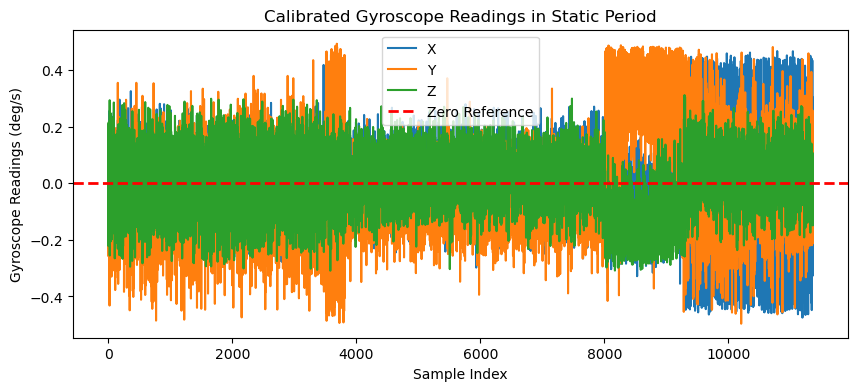

In [264]:
def runge_kutta_integration(data, bias):
    """ Uses Runge-Kutta method to integrate gyroscope data into orientation. """
    orientation = R.identity()
    integrated_gravity = []
    dt = np.mean(np.diff(static_timestamps)) / 1000.0

    for omega in data:
        omega = (omega - bias) * np.pi / 180
        omega_quat = R.from_rotvec(omega * dt)  # Convert to quaternion rotation
        orientation = omega_quat * orientation
        integrated_gravity.append(orientation.apply([0, 0, 9.81]))  # Apply to gravity vector

    return np.array(integrated_gravity)

def gyro_calibration(params, gyro_data, return_corrected=False):
    """ Calibration function for gyroscope. """
    scale_factors = np.diag(params[:3])
    misalignment = np.array([[1, params[3], params[4]],
                              [params[5], 1, params[6]],
                              [params[7], params[8], 1]])
    # Apply calibration (bias already removed before integration)
    corrected = (gyro_data @ scale_factors) @ misalignment.T
    
    if return_corrected:
        return corrected
    return np.linalg.norm(corrected, axis=1)

def apply_gyro_calibration(static_gyro_data):
    bounds_gyro = ([0.95, 0.95, 0.95, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05],  
                [1.05, 1.05, 1.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
    initial_guess_gyro = np.array([1, 1, 1, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

    gyro_bias = np.mean(static_gyro_data, axis=0)    
    gyro_gravity_vectors = runge_kutta_integration(static_gyro_data, gyro_bias)
    result = least_squares(gyro_calibration, initial_guess_gyro, args=(gyro_gravity_vectors,), bounds=bounds_gyro)
    gyro_corrected = gyro_calibration(result.x, static_gyro_data - gyro_bias, return_corrected=True)
    return gyro_corrected

def test_gyro_calibration(static_gyro_data):
    gyro_corrected = apply_gyro_calibration(static_gyro_data)
    gyro_mean = np.mean(gyro_corrected, axis=0)
    gyro_std = np.std(gyro_corrected, axis=0)

    print(f"\nFinal Mean Gyroscope Values (should be close to 0): {gyro_mean}")
    print(f"Standard Deviation (should be small): {gyro_std}")

    plt.figure(figsize=(10, 4))
    plt.plot(gyro_corrected, label=["X", "Y", "Z"])
    plt.axhline(0, color='r', linestyle='dashed', linewidth=2, label="Zero Reference")
    plt.xlabel("Sample Index")
    plt.ylabel("Gyroscope Readings (deg/s)")
    plt.title("Calibrated Gyroscope Readings in Static Period")
    plt.legend()
    plt.show()

test_gyro_calibration(remove_outliers_iqr(static_gyro_data))